In [24]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import numpy as np
import gc
import os
import optuna
import sqlite3

In [67]:
gc.collect()
df_full = pd.read_parquet('./data/l_vm_completa_train.parquet', engine='fastparquet')

In [68]:
# Optimizar tipos de datos numéricos
for col in df_full.select_dtypes(include=['int64']).columns:
    df_full[col] = pd.to_numeric(df_full[col], downcast='integer')
for col in df_full.select_dtypes(include=['float64']).columns:
    df_full[col] = pd.to_numeric(df_full[col], downcast='float')
# Variables categóricas
# categorical_features = ['ANIO','MES','TRIMESTRE','ID_CAT1','ID_CAT2','ID_CAT3','ID_BRAND','SKU_SIZE','CUSTOMER_ID','PRODUCT_ID','PLAN_PRECIOS_CUIDADOS']
categorical_features = ['ID_CAT1','ID_CAT2','ID_CAT3','ID_BRAND','PLAN_PRECIOS_CUIDADOS']
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_full[col] = df_full[col].astype('category')

In [69]:
# Variables predictoras y objetivo
# filtrar que en X el periodo sea menor o igual a 201910
# En x eliminar la columna 'CLASE' y 'CLASE_DELTA'
X = df_full[df_full['PERIODO'] <= 201910].drop(columns=['CLASE', 'CLASE_DELTA']) 
# Filtrar en y que el periodo sea menor o igual a 201910
y = df_full[df_full['PERIODO'] <= 201910]['CLASE']
# Agrega una columna 'CLASE_BIN' que sea 1 si 'CLASE' es mayor a 0, y 0 en caso contrario para clasificación binaria
# El tipo es cero o uno por lo que se convierte a int del menor tamaño posible
df_full['CLASE_BIN'] = (df_full['CLASE'] > 0).astype('int8')
y_bin = df_full[df_full['PERIODO'] <= 201910]['CLASE_BIN']

# Eliminar df_full para liberar memoria
del df_full
gc.collect()

0

In [70]:
# Definir los periodos de validación 201910
#periodos_valid = [201910]
periodos_valid = [201910]



# Separar train y cinco conjuntos de validación respetando la secuencia temporal
X_train = X[X['PERIODO'] < periodos_valid[0]]
y_train = y[X['PERIODO'] < periodos_valid[0]]
y_bin_train = y_bin[X['PERIODO'] < periodos_valid[0]]

X_val_list = [X[X['PERIODO'] == p] for p in periodos_valid]
y_val_list = [y[X['PERIODO'] == p] for p in periodos_valid]
y_bin_val_list = [y_bin[X['PERIODO'] == p] for p in periodos_valid]

del X, y, y_bin
gc.collect()

0

In [ ]:
# # Hacer un try-except para cargar el modelo de LightGBM para regresión
# try:
#     # Verificar si el archivo del modelo de regresión existe
#     if not os.path.exists('./modelos/lgbm_model_reg.txt'):
#         raise FileNotFoundError("El modelo de regresión no se encuentra en la ruta especificada.")
#     model_reg = lgb.Booster(model_file='./modelos/lgbm_model_reg.txt')
#     print("Modelo de regresión cargado exitosamente.")
# except FileNotFoundError:
#     model_reg = None
# Crear los datasets de LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
val_data_list = []
for i in range(len(periodos_valid)):
    val_dataset = lgb.Dataset(X_val_list[i], label=y_val_list[i], categorical_feature=categorical_features)
    # Inyectar PRODUCT_ID como atributo extra
    val_dataset.PRODUCT_ID = X_val_list[i]['PRODUCT_ID'].values
    val_data_list.append(val_dataset)

def mape_sum_lgb(y_pred, dataset):
    y_true = dataset.get_label()
    product_id = getattr(dataset, 'PRODUCT_ID', None)
    y_pred = np.where(y_pred < 0, 0, y_pred)
    denom = np.sum(np.abs(y_true))
    if denom == 0:
        return 'mape_sum', 0.0, False
    if product_id is not None:
        df_pred = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'PRODUCT_ID': product_id})
        mape = np.sum(np.abs(df_pred.groupby('PRODUCT_ID')['y_true'].sum() - df_pred.groupby('PRODUCT_ID')['y_pred'].sum())) / denom
    else:
        mape = np.sum(np.abs(y_true.sum() - y_pred.sum())) / denom
    mape = np.nan_to_num(mape, nan=0.0)
    return 'mape_sum', mape, False  # False: menor es mejor

def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'None',  # Solo métrica personalizada
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 31, 512),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 16),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 5.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 5.0),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'verbose': -1,
        'feature_pre_filter': False
    }

    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=val_data_list,
        valid_names=[f'validation_{p}' for p in periodos_valid],
        feval=mape_sum_lgb,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, first_metric_only=True),
            lgb.log_evaluation(period=50)
        ]
    )
    best_score = model.best_score[f'validation_{periodos_valid[0]}']['mape_sum']
    print(f"Trial {trial.number}: mape_sum={best_score:.5f}")
    return best_score

# Guardar resultados en base de datos sqlite
storage_url = "sqlite:///./modelos/optuna.db"
study = optuna.create_study(direction='minimize', study_name="lgbm_regression", storage=storage_url, load_if_exists=True)
study.optimize(objective, n_trials=50, show_progress_bar=True)  # Puedes ajustar n_trials

print("Mejores hiperparámetros encontrados:")
print(study.best_params)

# Entrena el modelo final con los mejores hiperparámetros encontrados
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'None'

model_reg = lgb.train(
    best_params,
    train_data,
    num_boost_round=50000,
    valid_sets=val_data_list,
    valid_names=[f'validation_{p}' for p in periodos_valid],
    feval=mape_sum_lgb,
    callbacks=[
        lgb.early_stopping(stopping_rounds=500, first_metric_only=True),
        lgb.log_evaluation(period=50)
    ]
)

os.makedirs('./modelos', exist_ok=True)
model_reg.save_model('./modelos/lgbm_model_reg.txt')

# {'num_leaves': 439, 'learning_rate': 0.02651028762503521, 'feature_fraction': 0.8720499830243962, 'bagging_fraction': 0.9846969614646556, 
# 'bagging_freq': 7, 'min_data_in_leaf': 59, 'max_depth': 16, 'lambda_l1': 0.23731324768160023, 'lambda_l2': 3.760900279594698, 
# 'min_gain_to_split': 0.03595413253429805}

In [65]:
best_params1 = {'num_leaves': 439, 'learning_rate': 0.02651028762503521, 'feature_fraction': 0.8720499830243962, 'bagging_fraction': 0.9846969614646556, 
'bagging_freq': 7, 'min_data_in_leaf': 59, 'max_depth': 16, 'lambda_l1': 0.23731324768160023, 'lambda_l2': 3.760900279594698, 
'min_gain_to_split': 0.03595413253429805}


In [71]:

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
model_reg_sin_val = lgb.train(
    best_params1,
    train_data,
    num_boost_round=850)

os.makedirs('./modelos', exist_ok=True)
model_reg.save_model('./modelos/lgbm_model_reg_sin_val.txt')

                      feature    importance
19    MEDIA_MOVIL_6M_CLI_PROD  1.089594e+08
51                 MEDIA_PROD  3.133154e+07
18    MEDIA_MOVIL_3M_CLI_PROD  3.051474e+07
49          CANT_PROD_CLI_PER  2.713561e+07
20   MEDIA_MOVIL_12M_CLI_PROD  2.701077e+07
11                CUSTOMER_ID  2.449911e+07
12                 PRODUCT_ID  1.616532e+07
14           CUST_REQUEST_QTY  1.375535e+07
39                  TN_LAG_06  1.213136e+07
36                  TN_LAG_01  1.200496e+07
38                  TN_LAG_03  8.316384e+06
29      DESVIO_MOVIL_12M_PROD  7.365879e+06
16                         TN  7.091124e+06
37                  TN_LAG_02  7.048521e+06
50             MEDIA_PROD_PER  7.024522e+06
10                   SKU_SIZE  6.323367e+06
2                         MES  6.282500e+06
0                     PERIODO  5.969150e+06
40                  TN_LAG_12  4.930522e+06
52                  MEDIA_PER  4.877069e+06
17                STOCK_FINAL  4.283315e+06
8                     ID_CAT3  3

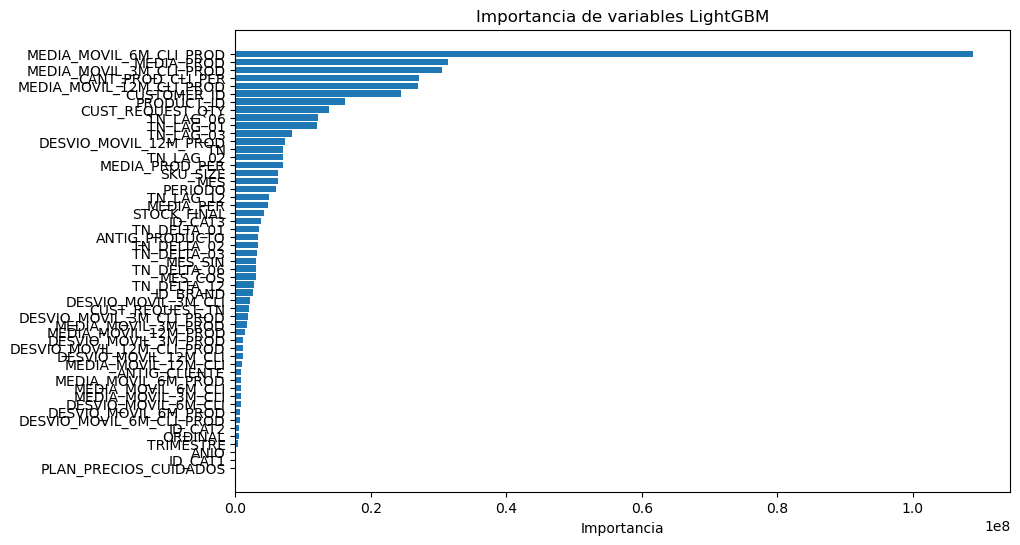

In [72]:
# Obtener la importancia de cada variable
importancia = model_reg.feature_importance(importance_type='gain')
nombres = X_train.columns

# Crear un DataFrame ordenado por importancia
df_importancia = pd.DataFrame({'feature': nombres, 'importance': importancia})
df_importancia = df_importancia.sort_values(by='importance', ascending=False)

# Mostrar las variables más importantes
print(df_importancia)

# Si quieres visualizarlo gráficamente:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(df_importancia['feature'], df_importancia['importance'])
plt.gca().invert_yaxis()
plt.title('Importancia de variables LightGBM')
plt.xlabel('Importancia')
plt.show()

In [92]:
# Cargo los datos sobre los que quiero hacer predicciones

gc.collect()
df_full = pd.read_parquet('./data/l_vm_completa_train.parquet', engine='fastparquet')
df_pred_full = df_full[df_full['PERIODO'] == 201910].drop(columns=['CLASE', 'CLASE_DELTA'])
y_obs = df_full[df_full['PERIODO'] == 201910]['CLASE']



In [93]:
# Convertir las variables categóricas a tipo 'category'
for col in categorical_features:
    df_pred_full[col] = df_pred_full[col].astype('category')

In [94]:
# Eliminar del dataframe df_pred_full la columna 'PREDICCIONES'
if 'PREDICCIONES' in df_pred_full.columns:
    df_pred_full.drop(columns=['PREDICCIONES'], inplace=True)

In [95]:

predictions = model_reg.predict(df_pred_full) 
df_pred_full['PREDICCIONES'] = predictions
# Hacer que las predicciones sean cero si son negativas
df_pred_full['PREDICCIONES'] = np.where(df_pred_full['PREDICCIONES'] < 0, 0, df_pred_full['PREDICCIONES'])
df_pred_full['CLASE'] = y_obs

In [99]:
# Generar Dataframe que contenga por cada PRODUCT_ID la suma de las predicciones y la suma de la clase observada
df_comp = df_pred_full.groupby('PRODUCT_ID').agg({'PREDICCIONES': 'sum', 'CLASE': 'sum'}).reset_index()
df_comp['DIF_ABS'] = np.abs(df_comp['PREDICCIONES'] - df_comp['CLASE'])
# ordernar por la diferencia absoluta
df_comp = df_comp.sort_values(by='DIF_ABS', ascending=False)
df_comp.head(20)


,PRODUCT_ID,PREDICCIONES,CLASE,DIF_ABS
7,20008,360.933487,195.36854,165.564947
0,20001,1657.863854,1504.68856,153.175294
13,20014,401.013688,272.02812,128.985568
79,20089,211.749222,102.33626,109.412962
17,20018,249.822172,141.63570,108.186472
22,20023,284.005300,180.58677,103.418530
12,20013,418.237445,318.00951,100.227935
40,20044,158.105268,59.61747,98.487798
10,20011,293.941409,392.25186,98.310451
11,20012,268.370356,173.13004,95.240316


   PERIODO         TN
0   201701  523.04609
1   201702  631.71430
2   201703  937.42393
3   201704  626.51768
4   201705  849.48973
5   201706  739.24267
6   201707  563.83449
7   201708  837.31906
8   201709  671.24800
9   201710  723.19292
10  201711  631.86060
11  201712  543.14221
12  201801  469.29224
13  201802  506.25385
14  201803  765.98901
15  201804  691.53246
16  201805  707.59267
17  201806  554.57063
18  201807  526.38149
19  201808  554.82147
20  201809  436.96269
21  201810  532.45644
22  201811  433.50170
23  201812  426.32899
24  201901  543.27828
25  201902  476.98787
26  201903  454.57037
27  201904  403.69191
28  201905  486.36682
29  201906  567.42091
30  201907  524.04994
31  201908  233.00983
32  201909  330.56343
33  201910  452.77197
34  201911  396.49833
35  201912  195.36854


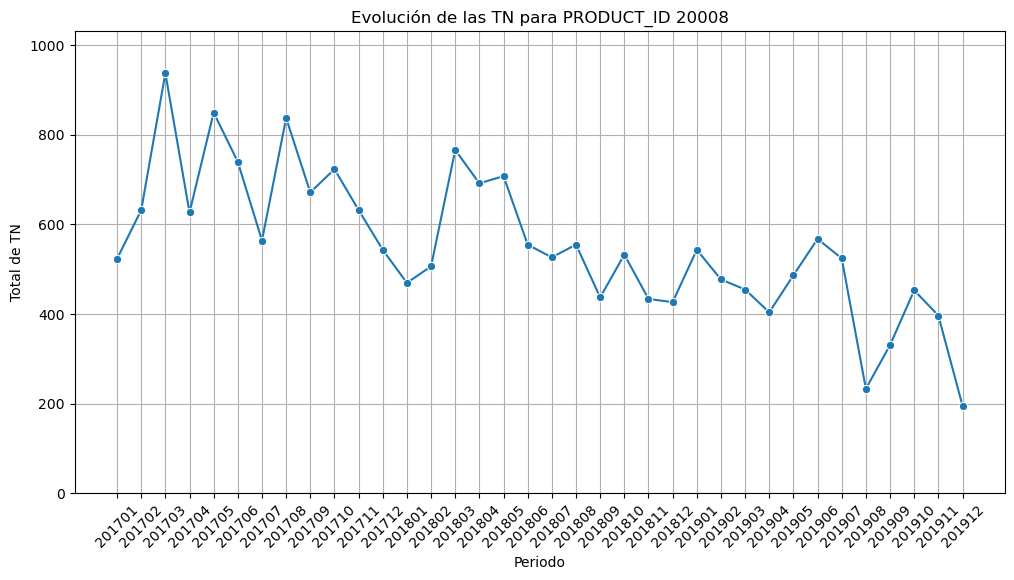

In [108]:
# Con los datos de df_full 
# Para el PRODUCT_ID 20008 armar un dataframe que totalice por periodo las TN

df_prod_20008 = df_full[df_full['PRODUCT_ID'] == 20008].groupby('PERIODO').agg({'TN': 'sum'}).reset_index()
# Convertir la columna 'PERIODO' a tipo string para que seaborn lo trate como categórico
df_prod_20008['PERIODO'] = df_prod_20008['PERIODO'].astype(str)
df_prod_20008
print(df_prod_20008)

# Hacer un gráfico que muestre la evolución de las TN por periodo con seaborn como una curva con el eje y comenzando en cero
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_prod_20008, x='PERIODO', y='TN', marker='o')
plt.title('Evolución de las TN para PRODUCT_ID 20008')
plt.xlabel('Periodo')
plt.ylabel('Total de TN')
plt.xticks(rotation=45)
plt.ylim(0, df_prod_20008['TN'].max() * 1.1)  # Ajustar el eje y para que comience en cero
plt.grid()
plt.show()
# Guardar el DataFrame df_comp en un archivo CSV


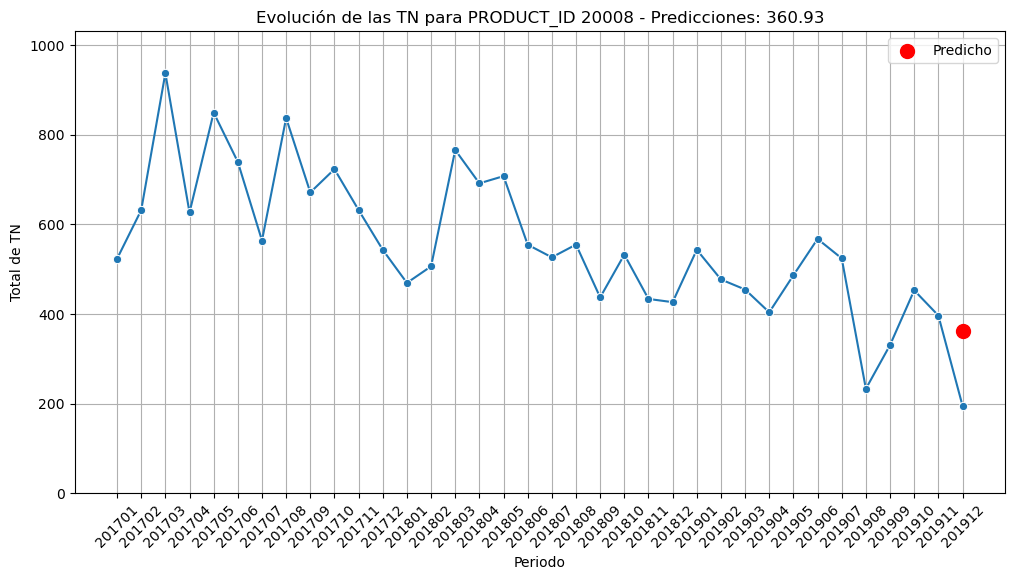

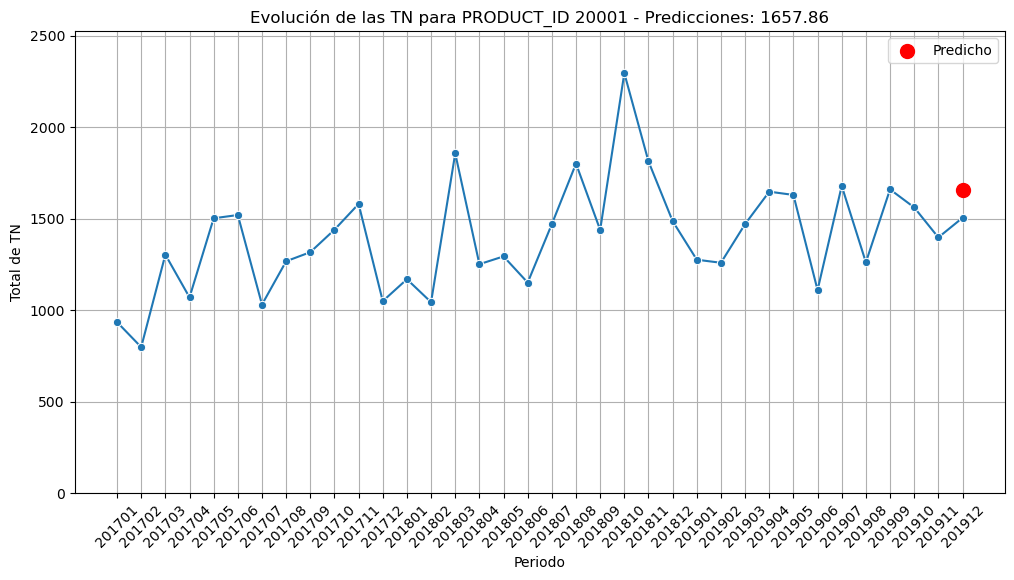

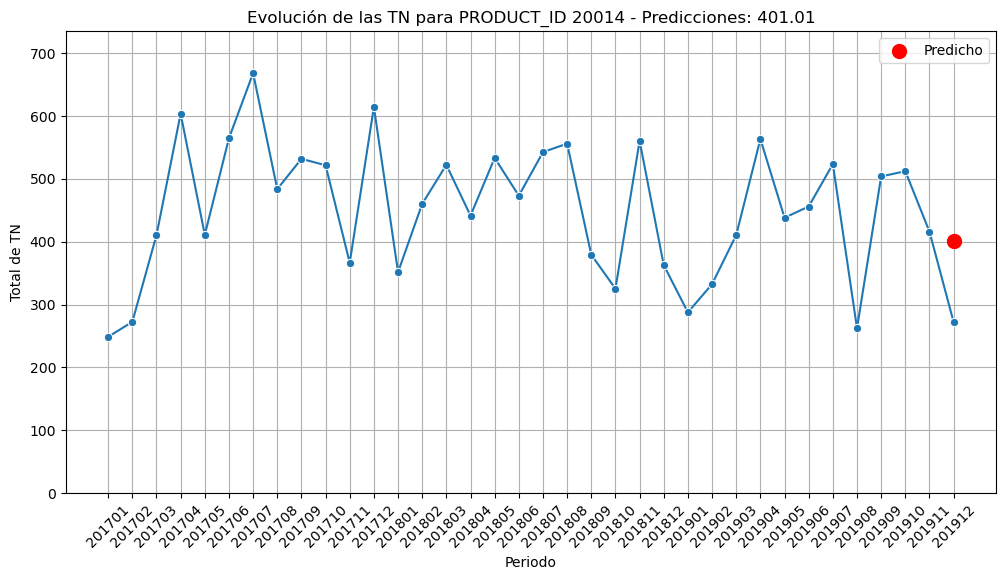

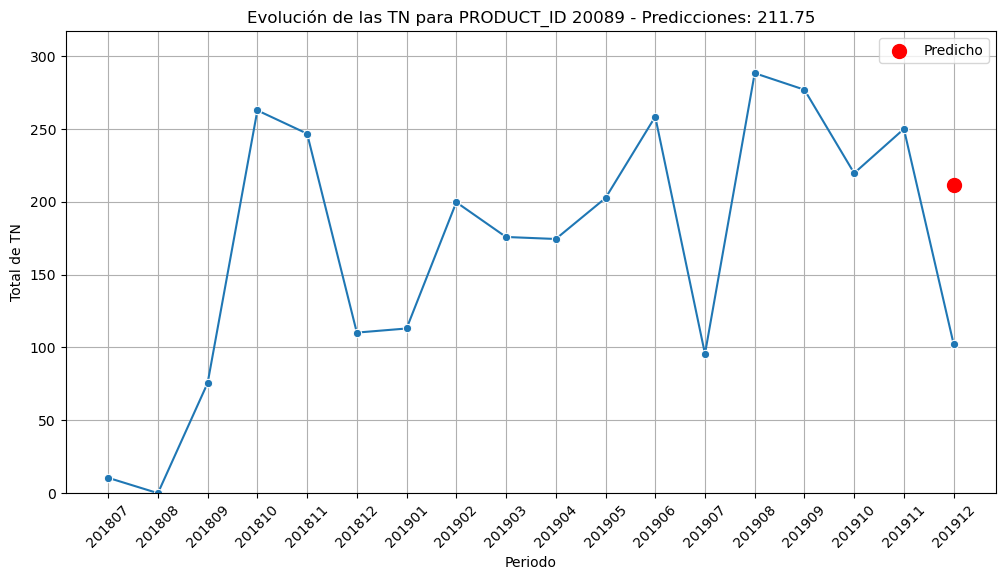

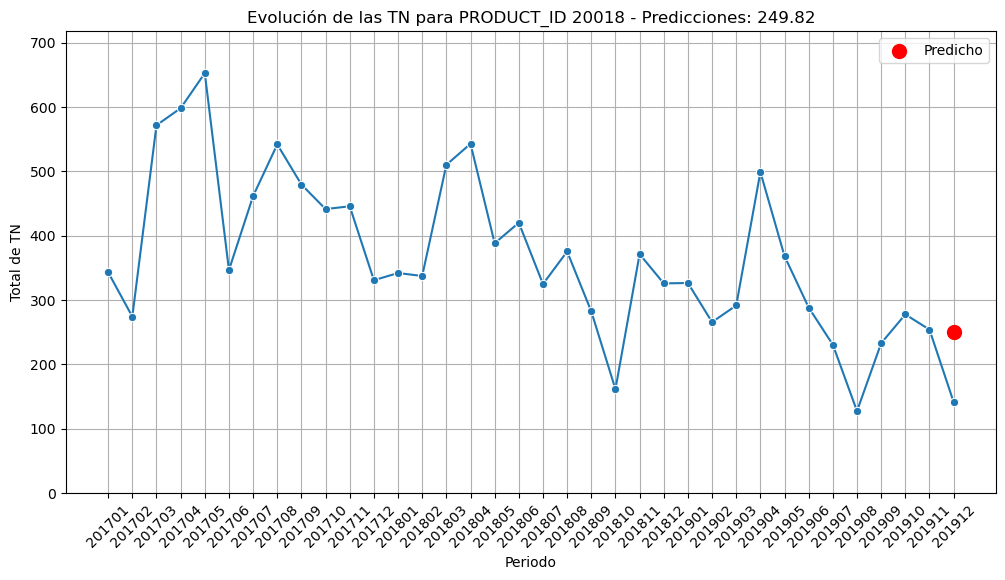

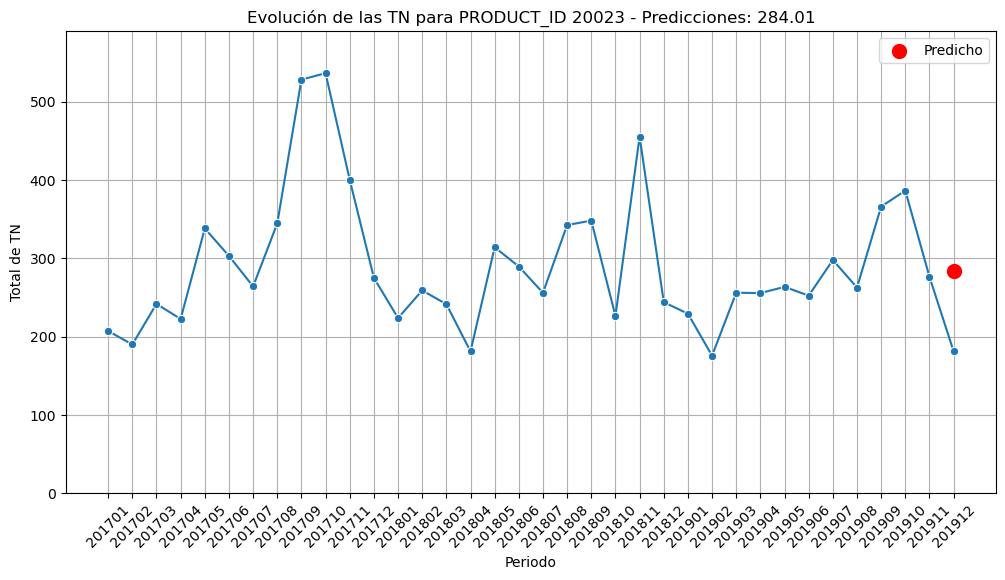

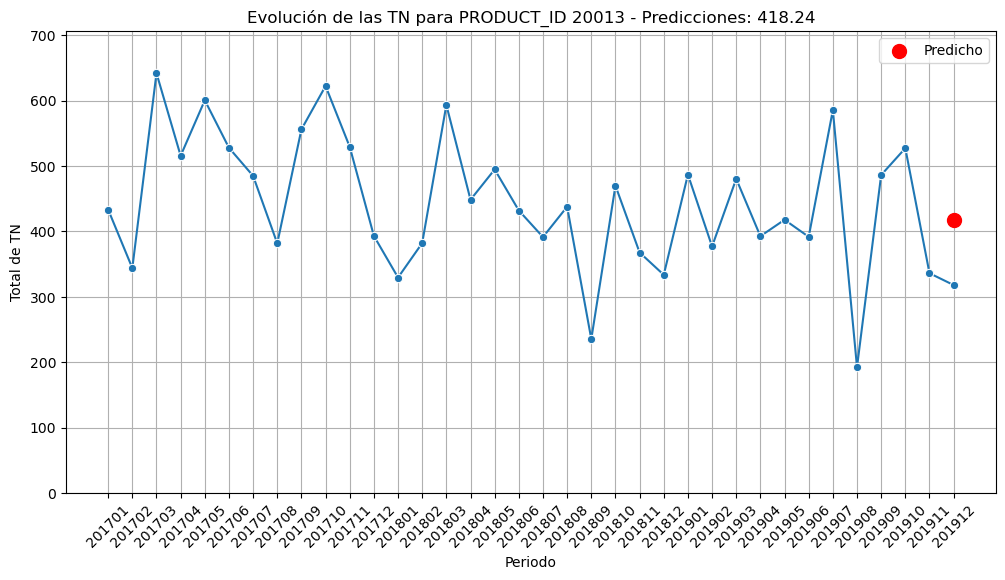

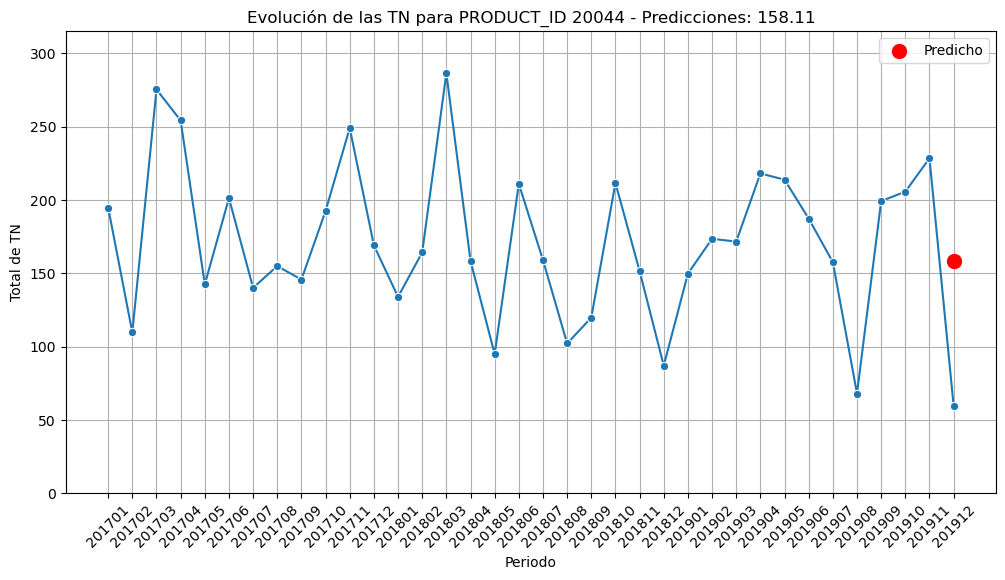

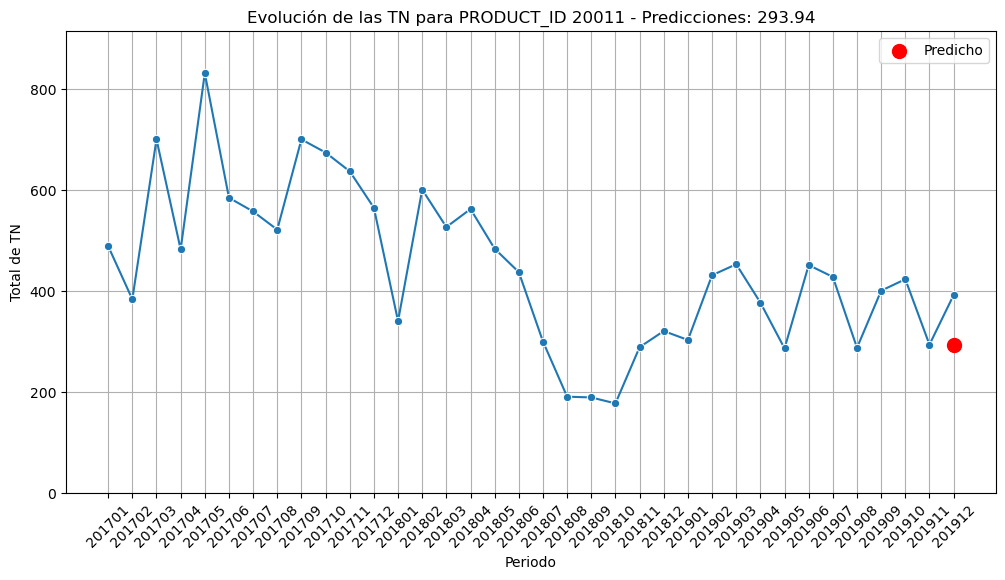

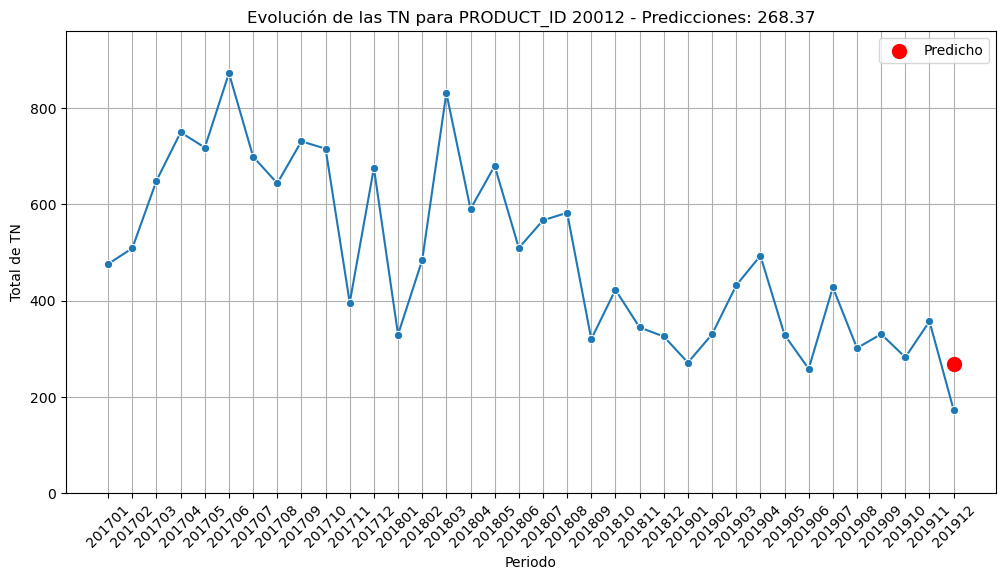

In [116]:
# Para los primeros 10 PRODUCT_ID de df_comp generar graficos como el anterior agregando resaltado en el gráfico en el periodo 201912
# el valor PREDICCIONES de DF_COMP para el PRODUCT_ID en el título del gráfico
for product_id in df_comp['PRODUCT_ID'].head(10):
    df_prod = df_full[df_full['PRODUCT_ID'] == product_id].groupby('PERIODO').agg({'TN': 'sum'}).reset_index()
    df_prod['PERIODO'] = df_prod['PERIODO'].astype(str)

    # Obtener el valor de TN para el periodo '201912'
    highlight_period = '201912'
    highlight_row = df_prod[df_prod['PERIODO'] == highlight_period]
    highlight_value = highlight_row['TN'].values[0] if not highlight_row.empty else None

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_prod, x='PERIODO', y='TN', marker='o')
    pred_value = df_comp[df_comp["PRODUCT_ID"] == product_id]["PREDICCIONES"].values[0]
    plt.title(f'Evolución de las TN para PRODUCT_ID {product_id} - Predicciones: {pred_value:.2f}')
    plt.xlabel('Periodo')
    plt.ylabel('Total de TN')
    plt.xticks(rotation=45)
    plt.ylim(0, df_prod['TN'].max() * 1.1)  # Ajustar el eje y para que comience en cero
    plt.scatter('201912', pred_value, color='red', s=100, zorder=5, label='Predicho')
    plt.legend()
    plt.grid()
    plt.show()



In [64]:
# Generar el DataFrame de salida que contiene PRODUCT_ID y la suma de las predicciones por PRODUCT_ID
df_output = df_pred_full.groupby('PRODUCT_ID')['PREDICCIONES'].sum().reset_index()
# Hacer que la columna de predicciones sea mayor que cero
df_output['PREDICCIONES'] = np.where(df_output['PREDICCIONES'] < 0, 0, df_output['PREDICCIONES'])
df_output.head(10)
# Renombrar las columnas como product_id y tn
df_output.columns = ['product_id', 'tn']
# Guardar el DataFrame de salida en un archivo CSV
df_output.to_csv('./modelos/optuna_lgbm_predictions_sin_val_sin_negativos.csv', index=False)
# Contar los valores negativos en df_output
negativos = df_output[df_output['tn'] < 0].shape[0]
print(f"Número de valores negativos en las predicciones: {negativos}")

Número de valores negativos en las predicciones: 0
